In [1]:
from datasets import load_dataset

raw_datasets = load_dataset("squad")

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [2]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

### During training:
There is only one possible answer. We can double-check this by using the Dataset.filter() method:

In [3]:
raw_datasets["train"].filter(lambda x: len(x["answers"]["text"]) != 1)

Filter:   0%|          | 0/87599 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 0
})

### For evaluation, however:
There are several possible answers for each sample, which may be the same or different

In [4]:
print(raw_datasets["validation"][0]["answers"])
print(raw_datasets["validation"][2]["answers"])

{'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'answer_start': [177, 177, 177]}
{'text': ['Santa Clara, California', "Levi's Stadium", "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."], 'answer_start': [403, 355, 355]}


Let’s start with preprocessing the training data. The hard part will be to generate labels for the question’s answer, which will be the start and end positions of the tokens corresponding to the answer inside the context.

First, we need to convert the ```text in the input into IDs``` the model can make sense of, using a tokenizer:

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

We can pass to our tokenizer the question and the context together, and it will properly insert the special tokens to form a sentence like this:

[CLS] question [SEP] context [SEP]

In [ ]:
context = raw_datasets["train"][0]["context"]
question = raw_datasets["train"][0]["question"]

inputs = tokenizer(question, context)
tokenizer.decode(inputs["input_ids"])

The labels will then be the index of the tokens starting and ending the answer, and the model will be tasked to predicted one start and end logit per token in the input, with the theoretical labels being as follow:
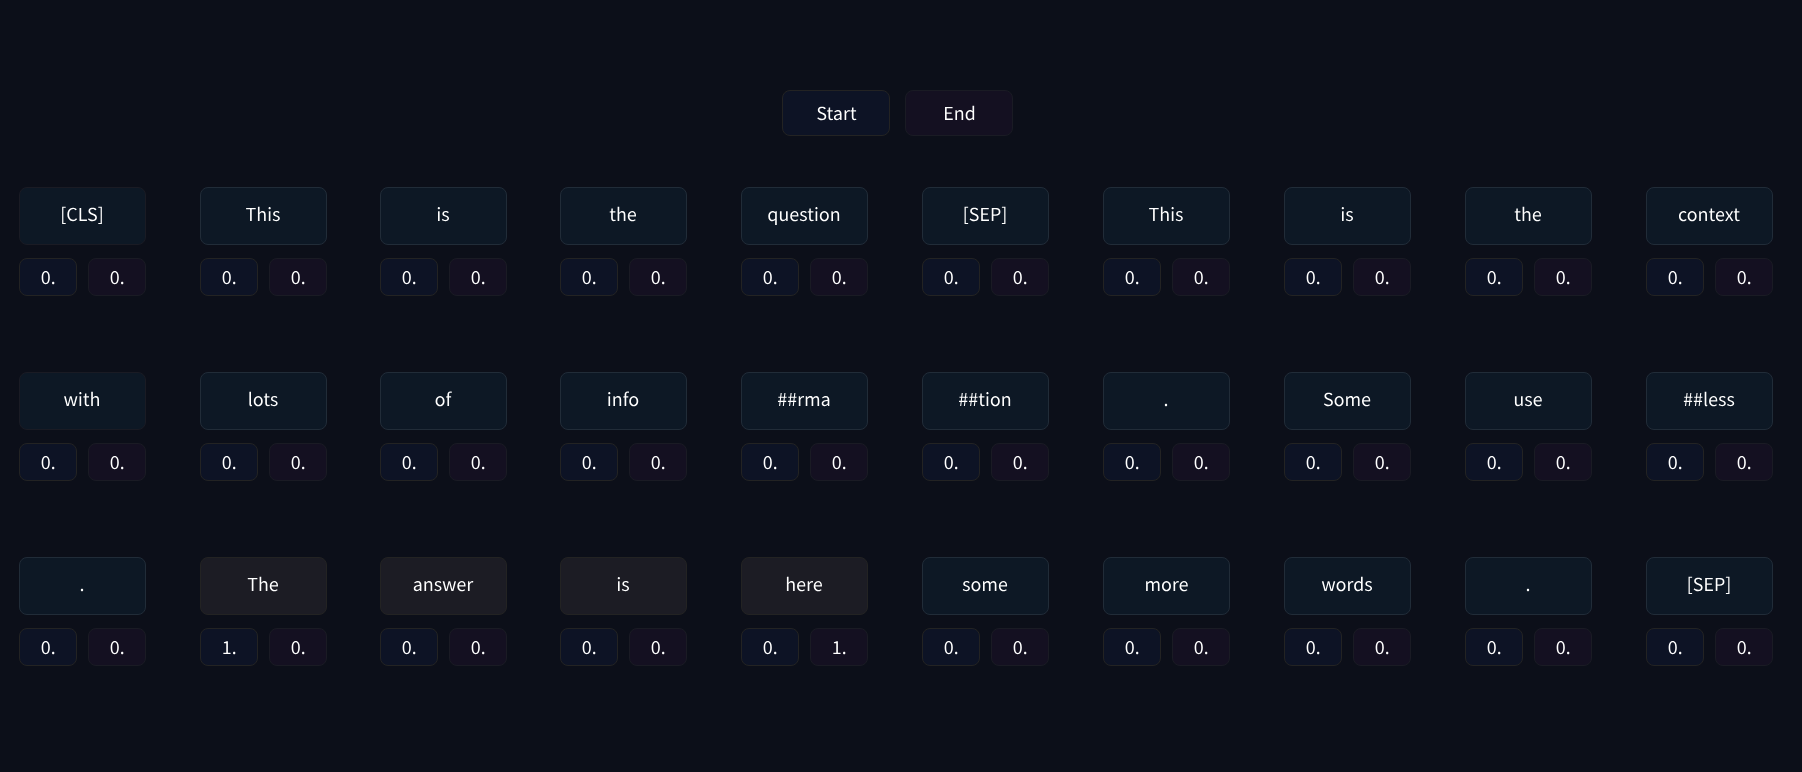

In this case the context is not too long, but some of the examples in the dataset have very long contexts that will exceed the maximum length we set (which is 384 in this case). 

To see how this works using the current example, we can limit the length to 100 and use a sliding window of 50 tokens. As a reminder, we use:

max_length to set the maximum length (here 100)
truncation="only_second" to truncate the context (which is in the second position) when the question with its context is too long
stride to set the number of overlapping tokens between two successive chunks (here 50)
return_overflowing_tokens=True to let the tokenizer know we want the overflowing tokens

In [7]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))
    

[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basi [SEP]
[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin [SEP]
[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Next to the Main Building is the B

As we can see, our example has been in split into four inputs, each of them containing the question and some part of the context. Note that the answer to the question (“Bernadette Soubirous”) only appears in the third and last inputs, so by dealing with long contexts in this way we will create some training examples where the answer is not included in the context. For those examples, the labels will be start_position = end_position = 0 (so we predict the [CLS] token). We will also set those labels in the unfortunate case where the answer has been truncated so that we only have the start (or end) of it. For the examples where the answer is fully in the context, the labels will be the index of the token where the answer starts and the index of the token where the answer ends.



In [8]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

As we can see, we get back the usual input IDs, token type IDs, and attention mask, as well as the offset mapping we required and an extra key, overflow_to_sample_mapping. The corresponding value will be of use to us when we tokenize several texts at the same time (which we should do to benefit from the fact that our tokenizer is backed by Rust). Since one sample can give several features, it maps each feature to the example it originated from. Because here we only tokenized one example, we get a list of 0s:

In [9]:
inputs["overflow_to_sample_mapping"]

[0, 0, 0, 0]

In [10]:
inputs = tokenizer(
    raw_datasets["train"][2:6]["question"],
    raw_datasets["train"][2:6]["context"],
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

print(f"The 4 examples gave {len(inputs['input_ids'])} features.")
print(f"Here is where each comes from: {inputs['overflow_to_sample_mapping']}.")

The 4 examples gave 19 features.
Here is where each comes from: [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3].


As we can see, the first three examples (at indices 2, 3, and 4 in the training set) each gave four features and the last example (at index 5 in the training set) gave 7 features.

This information will be useful to map each feature we get to its corresponding label. As mentioned earlier, those labels are:

(0, 0) if the answer is not in the corresponding span of the context
(start_position, end_position) if the answer is in the corresponding span of the context, with start_position being the index of the token (in the input IDs) at the start of the answer and end_position being the index of the token (in the input IDs) where the answer ends
To determine which of these is the case and, if relevant, the positions of the tokens, we first find the indices that start and end the context in the input IDs. We could use the token type IDs to do this, but since those do not necessarily exist for all models (DistilBERT does not require them, for instance), we’ll instead use the sequence_ids() method of the BatchEncoding our tokenizer returns.

Once we have those token indices, we look at the corresponding offsets, which are tuples of two integers representing the span of characters inside the original context. We can thus detect if the chunk of the context in this feature starts after the answer or ends before the answer begins (in which case the label is (0, 0)). If that’s not the case, we loop to find the first and last token of the answer:

In [11]:
answers = raw_datasets["train"][2:6]["answers"]
start_positions = []
end_positions = []

for i, offset in enumerate(inputs["offset_mapping"]):
    sample_idx = inputs["overflow_to_sample_mapping"][i]
    answer = answers[sample_idx]
    start_char = answer["answer_start"][0]
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    # If the answer is not fully inside the context, label is (0, 0)
    if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
        start_positions.append(0)
        end_positions.append(0)
    else:
        # Otherwise it's the start and end token positions
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

start_positions, end_positions

([83, 51, 19, 0, 0, 64, 27, 0, 34, 0, 0, 0, 67, 34, 0, 0, 0, 0, 0],
 [85, 53, 21, 0, 0, 70, 33, 0, 40, 0, 0, 0, 68, 35, 0, 0, 0, 0, 0])

Now that we have seen step by step how to preprocess our training data, we can group it in a function we will apply on the whole training dataset. We’ll pad every feature to the maximum length we set, as most of the contexts will be long (and the corresponding samples will be split into several features), so there is no real benefit to applying dynamic padding here:

In [12]:
max_length = 384
stride = 128


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

Note that we defined two constants to determine the maximum length used as well as the length of the sliding window, and that we added a tiny bit of cleanup before tokenizing: some of the questions in the SQuAD dataset have extra spaces at the beginning and the end that don’t add anything (and take up space when being tokenized if you use a model like RoBERTa), so we removed those extra spaces.

To apply this function to the whole training set, we use the Dataset.map() method with the batched=True flag. It’s necessary here as we are changing the length of the dataset (since one example can give several training features):

In [13]:
train_dataset = raw_datasets["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)
len(raw_datasets["train"]), len(train_dataset)

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

(87599, 88729)

Preprocessing the validation data will be slightly easier as we don’t need to generate labels (unless we want to compute a validation loss, but that number won’t really help us understand how good the model is). The real joy will be to interpret the predictions of the model into spans of the original context. For this, we will just need to store both the offset mappings and some way to match each created feature to the original example it comes from. Since there is an ID column in the original dataset, we’ll use that ID.

The only thing we’ll add here is a tiny bit of cleanup of the offset mappings. They will contain offsets for the question and the context, but once we’re in the post-processing stage we won’t have any way to know which part of the input IDs corresponded to the context and which part was the question (the sequence_ids() method we used is available for the output of the tokenizer only). So, we’ll set the offsets corresponding to the question to None

In [14]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [15]:
validation_dataset = raw_datasets["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)
len(raw_datasets["validation"]), len(validation_dataset)

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

(10570, 10822)

### Fine-tuning
The training code for this example will look a lot like the code in the previous sections — the hardest thing will be to write the compute_metrics() function. Since we padded all the samples to the maximum length we set, there is no data collator to define, so this metric computation is really the only thing we have to worry about. The difficult part will be to post-process the model predictions into spans of text in the original examples; once we have done that, the metric from the hugging face Datasets library will do most of the work for us.

### Post-processing
The model will output logits for the start and end positions of the answer in the input IDs, as we saw during our exploration of the question-answering pipeline. The post-processing step will be similar to what we did there, so here’s a quick reminder of the actions we took:

We masked the start and end logits corresponding to tokens outside of the context.
We then converted the start and end logits into probabilities using a softmax.
We attributed a score to each (start_token, end_token) pair by taking the product of the corresponding two probabilities.
We looked for the pair with the maximum score that yielded a valid answer (e.g., a start_token lower than end_token).
Here we will change this process slightly because we don’t need to compute actual scores (just the predicted answer). This means we can skip the softmax step. To go faster, we also won’t score all the possible (start_token, end_token) pairs, but only the ones corresponding to the highest n_best logits (with n_best=20). Since we will skip the softmax, those scores will be logit scores, and will be obtained by taking the sum of the start and end logits (instead of the product, because of the rule

log(ab)=(log(a)+log(b)).

To demonstrate all of this, we will need some kind of predictions. Since we have not trained our model yet, we are going to use the default model for the QA pipeline to generate some predictions on a small part of the validation set. We can use the same processing function as before; because it relies on the global constant tokenizer, we just have to change that object to the tokenizer of the model we want to use temporarily:

In [16]:
small_eval_set = raw_datasets["validation"].select(range(100))
trained_checkpoint = "distilbert-base-cased-distilled-squad"

tokenizer = AutoTokenizer.from_pretrained(trained_checkpoint)
eval_set = small_eval_set.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


We then remove the columns of our eval_set that are not expected by the model, build a batch with all of that small validation set, and pass it through the model. If a GPU is available, we use it to go faster:

In [18]:
import torch
from transformers import AutoModelForQuestionAnswering

eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
eval_set_for_model.set_format("torch")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch = {k: eval_set_for_model[k].to(device) for k in eval_set_for_model.column_names}
trained_model = AutoModelForQuestionAnswering.from_pretrained(trained_checkpoint).to(
    device
)

with torch.no_grad():
    outputs = trained_model(**batch)

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

Since the Trainer will give us predictions as NumPy arrays, we grab the start and end logits and convert them to that format:

In [19]:
start_logits = outputs.start_logits.cpu().numpy()
end_logits = outputs.end_logits.cpu().numpy()

Now, we need to find the predicted answer for each example in our small_eval_set. One example may have been split into several features in eval_set, so the first step is to map each example in small_eval_set to the corresponding features in eval_set

In [20]:
import collections

example_to_features = collections.defaultdict(list)
for idx, feature in enumerate(eval_set):
    example_to_features[feature["example_id"]].append(idx)

With this in hand, we can really get to work by looping through all the examples and, for each example, through all the associated features. As we said before, we’ll look at the logit scores for the n_best start logits and end logits, excluding positions that give:

An answer that wouldn’t be inside the context
An answer with negative length
An answer that is too long (we limit the possibilities at max_answer_length=30)
Once we have all the scored possible answers for one example, we just pick the one with the best logit score:

In [21]:
import numpy as np

n_best = 20
max_answer_length = 30
predicted_answers = []

for example in small_eval_set:
    example_id = example["id"]
    context = example["context"]
    answers = []

    for feature_index in example_to_features[example_id]:
        start_logit = start_logits[feature_index]
        end_logit = end_logits[feature_index]
        offsets = eval_set["offset_mapping"][feature_index]

        start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
        end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
        for start_index in start_indexes:
            for end_index in end_indexes:
                # Skip answers that are not fully in the context
                if offsets[start_index] is None or offsets[end_index] is None:
                    continue
                # Skip answers with a length that is either < 0 or > max_answer_length.
                if (
                    end_index < start_index
                    or end_index - start_index + 1 > max_answer_length
                ):
                    continue

                answers.append(
                    {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                )

    best_answer = max(answers, key=lambda x: x["logit_score"])
    predicted_answers.append({"id": example_id, "prediction_text": best_answer["text"]})

The final format of the predicted answers is the one that will be expected by the metric we will use. As usual, we can load it with the help of the 🤗 Evaluate library:

In [22]:
! pip install evaluate
import evaluate

metric = evaluate.load("squad")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.4 MB/s eta 0:00:00a 0:00:01


This metric expects the predicted answers in the format we saw above (a list of dictionaries with one key for the ID of the example and one key for the predicted text) and the theoretical answers in the format below (a list of dictionaries with one key for the ID of the example and one key for the possible answers):



In [23]:
theoretical_answers = [
    {"id": ex["id"], "answers": ex["answers"]} for ex in small_eval_set
]
print(predicted_answers[0])
print(theoretical_answers[0])

{'id': '56be4db0acb8001400a502ec', 'prediction_text': 'Denver Broncos'}
{'id': '56be4db0acb8001400a502ec', 'answers': {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'answer_start': [177, 177, 177]}}


In [24]:
metric.compute(predictions=predicted_answers, references=theoretical_answers)


{'exact_match': 83.0, 'f1': 88.25000000000004}

Again, that’s rather good considering that according to its paper DistilBERT fine-tuned on SQuAD obtains 79.1 and 86.9 for those scores on the whole dataset.

Now let’s put everything we just did in a compute_metrics() function that we will use in the Trainer. Normally, that compute_metrics() function only receives a tuple eval_preds with logits and labels. Here we will need a bit more, as we have to look in the dataset of features for the offset and in the dataset of examples for the original contexts, so we won’t be able to use this function to get regular evaluation results during training. We will only use it at the end of training to check the results.

The compute_metrics() function groups the same steps as before; we just add a small check in case we don’t come up with any valid answers (in which case we predict an empty string).

In [25]:
from tqdm.auto import tqdm


def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [26]:
compute_metrics(start_logits, end_logits, eval_set, small_eval_set)


  0%|          | 0/100 [00:00<?, ?it/s]

{'exact_match': 83.0, 'f1': 88.25000000000004}

### Fine-tuning the model
we are now ready to train our model. Let’s create it first, using the AutoModelForQuestionAnswering class like before:

In [27]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


As usual, we get a warning that some weights are not used (the ones from the pretraining head) and some others are initialized randomly (the ones for the question answering head). You should be used to this by now, but that means this model is not ready to be used just yet and needs fine-tuning — good thing we’re about to do that!



In [28]:
# from huggingface_hub import notebook_login

# notebook_login()

we can define our TrainingArguments. As we said when we defined our function to compute the metric, we won’t be able to have a regular evaluation loop because of the signature of the compute_metrics() function. We could write our own subclass of Trainer to do this (an approach you can find in the question answering example script), but that’s a bit too long for this section. Instead, we will only evaluate the model at the end of training here and show you how to do a regular evaluation in “A custom training loop” below.

This is really where the Trainer API shows its limits and the 🤗 Accelerate library shines: customizing the class to a specific use case can be painful, but tweaking a fully exposed training loop is easy.

In [29]:
from transformers import TrainingArguments

args = TrainingArguments(
    "bert-finetuned-squad",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
)

In [30]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)
trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,2.261800
1000,1.471600
1500,1.349100
2000,1.233200
2500,1.177100
3000,1.143500
3500,1.117700
4000,1.112800
4500,1.086500
5000,1.047200


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=16638, training_loss=0.8764314556339639, metrics={'train_runtime': 11242.1674, 'train_samples_per_second': 23.678, 'train_steps_per_second': 1.48, 'total_flos': 5.216534983896422e+16, 'train_loss': 0.8764314556339639, 'epoch': 3.0})

Once the training is complete, we can finally evaluate our model (and pray we didn’t spend all that compute time on nothing). The predict() method of the Trainer will return a tuple where the first elements will be the predictions of the model (here a pair with the start and end logits). We send this to our compute_metrics() function:

In [33]:
predictions, _, _ = trainer.predict(validation_dataset)
start_logits, end_logits = predictions
compute_metrics(start_logits, end_logits, validation_dataset, raw_datasets["validation"])

  0%|          | 0/10570 [00:00<?, ?it/s]

{'exact_match': 80.9271523178808, 'f1': 88.38187811724715}

Great! As a comparison, the baseline scores reported in the BERT article for this model are 80.8 and 88.5, so we’re right where we should be.

Finally, we use the push_to_hub() method to make sure we upload the latest version of the model:

In [36]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "huggingface-course/bert-finetuned-squad"
question_answerer = pipeline("question-answering", model=model_checkpoint)

context = """
🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question = "Which deep learning libraries back 🤗 Transformers?"
question_answerer(question=question, context=context)

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/431M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

{'score': 0.9978997707366943,
 'start': 78,
 'end': 105,
 'answer': 'Jax, PyTorch and TensorFlow'}